In [1]:
import os
import shutil
import matplotlib.pyplot as plt 
import cv2 as cv 
import numpy as np
from PIL import Image
import glob
import torch
import torchvision

# Prepare dataset

In [2]:
%cd ../

/home/gomaa/Ai/projects/Car-Damage-Segmentation


/home/gomaa/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
project_dir = os.getcwd()
print(project_dir)

/home/gomaa/Ai/projects/Car-Damage-Segmentation


In [4]:
data_path = os.path.join(project_dir, "data")
print(data_path)

/home/gomaa/Ai/projects/Car-Damage-Segmentation/data


In [5]:
os.listdir(data_path)

['dataset', 'Car-Damages-5', 'Unet_dataset']

In [6]:
original_dataset_name = "Car-Damages-5"
original_dataset_path = os.path.join(data_path, original_dataset_name)
print(original_dataset_path)

/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5


In [7]:
dataset_dir_name = "Unet_dataset"
dataset_dir_path = os.path.join(data_path,dataset_dir_name)
sub_dir = ['train','valid','test']
if dataset_dir_name not in os.listdir(data_path):
    os.mkdir(dataset_dir_path)
    print(f"Created {dataset_dir_path}")

    for dir in sub_dir:
        subdir_path = os.path.join(dataset_dir_path,dir)
        os.mkdir(subdir_path)
        os.mkdir(os.path.join(subdir_path,'images'))
        os.mkdir(os.path.join(subdir_path,'masks'))
else:
    print(f"{dataset_dir_path} already exists.")

/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Unet_dataset already exists.


In [8]:
def load_imgs(dataset_dir, from_yolo=False):
    imgs = {}
    if from_yolo:
        train_imgs = glob.glob(os.path.join(dataset_dir,'train/images/*.jpg'))
        valid_imgs = glob.glob(os.path.join(dataset_dir,'valid/images/*.jpg'))
        test_imgs = glob.glob(os.path.join(dataset_dir,'test/images/*.jpg'))
    else:
        train_imgs = glob.glob(os.path.join(dataset_dir,'train/*.jpg'))
        valid_imgs = glob.glob(os.path.join(dataset_dir,'valid/*.jpg'))
        test_imgs = glob.glob(os.path.join(dataset_dir,'test/*.jpg'))

    imgs['train'] = sorted(train_imgs)
    imgs['valid'] = sorted(valid_imgs)
    imgs['test'] = sorted(test_imgs)


    print(len(imgs['train']))
    print(len(imgs['valid']))
    print(len(imgs['test']))

    return imgs


In [9]:
def load_masks(dataset_dir, from_yolo=False):
    masks = {}
    
    if from_yolo:
        train_masks = glob.glob(os.path.join(dataset_dir,'train/labels/*.png'))
        valid_masks = glob.glob(os.path.join(dataset_dir,'valid/labels/*.png'))
        test_masks = glob.glob(os.path.join(dataset_dir,'test/labels/*.png'))
    else: 
        train_masks = glob.glob(os.path.join(dataset_dir,'train/*.png'))
        valid_masks = glob.glob(os.path.join(dataset_dir,'valid/*.png'))
        test_masks = glob.glob(os.path.join(dataset_dir,'test/*.png'))
    masks['train'] = sorted(train_masks)
    masks['valid'] = sorted(valid_masks)
    masks['test'] = sorted(test_masks)

    print(len(masks['train']))
    print(len(masks['valid']))
    print(len(masks['test']))

    return masks

In [10]:
images = load_imgs(original_dataset_path)
masks  = load_masks(original_dataset_path)

502
68
28
502
68
28


In [11]:
sub_dirs = ['train', 'valid', 'test']
for dir in sub_dirs:
    dst_i = os.path.join(dataset_dir_path,f"{dir}/images")
    for img in images[dir]:
        if img not in os.listdir(dst_i):
            shutil.copy(img, os.path.join(dst_i))

    dst_m = os.path.join(dataset_dir_path,f"{dir}/masks")
    for mask in masks[dir]:
        if mask not in os.listdir(dst_m):
            base_name = os.path.basename(mask)
            shutil.copy(mask, os.path.join(dst_m,base_name))
            os.rename(os.path.join(dst_m,base_name), os.path.join(dst_m,base_name.replace("_mask","")))
            



In [12]:
from torch.utils.data import Dataset, DataLoader

In [45]:
class MaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None):
        super().__init__()
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms

        self.images = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name.replace('jpg','png'))

        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img.astype('float32')
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask.astype('int64')

        label_map = {0:0, 3:1, 4:2}

        for k,v in label_map.items():
            mask[mask==k] = v

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].long()

        return img, mask



In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [35]:
train_tf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(p=0.4),
    A.Resize(256, 256),
    ToTensorV2()
], is_check_shapes=False)

valid_tf = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
], is_check_shapes=False)


/home/gomaa/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [46]:
train_dataset = MaskDataset(os.path.join(dataset_dir_path, "train/images"), os.path.join(dataset_dir_path, "train/masks"), transforms=train_tf)
valid_dataset = MaskDataset(os.path.join(dataset_dir_path, "valid/images"), os.path.join(dataset_dir_path, "valid/masks"), transforms=valid_tf)

trainset_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validset_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)


In [34]:
import os
from PIL import Image
from typing import Optional, Tuple, Dict

def print_image_sizes(directory_path: str, supported_extensions: Optional[Tuple[str, ...]] = ('.png', '.jpg', '.jpeg')) -> None:
    """
    Scans a directory (and its subdirectories) for image files 
    and prints the file path and its dimensions (width x height).

    Args:
        directory_path: The path to the directory to scan.
        supported_extensions: A tuple of file extensions to look for.
    """
    sizes = set()
    # Check if the provided path is a valid directory
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at path: {directory_path}")
        return

    print(f"--- Scanning directory: {directory_path} for images ---")
    found_count = 0

    # os.walk traverses the directory tree
    for root, _, files in os.walk(directory_path):
        for file in files:
            # Check if the file has a supported image extension
            if file.lower().endswith(supported_extensions):
                file_path = os.path.join(root, file)
                
                try:
                    # Use PIL to open the image and get its size
                    with Image.open(file_path) as img:
                        width, height = img.size
                        sizes.add(img.size)
                        print(f"Path: {file_path}")
                        print(f"  Size: {width} x {height}")

                        found_count += 1
                        
                except Exception as e:
                    # Handle files that match the extension but are corrupted
                    print(f"Warning: Could not read image file at {file_path}. Error: {e}")

    if found_count == 0:
        print(f"No images found with extensions {supported_extensions} in the directory or its subdirectories.")
    else:
        print(f"--- Scan complete. Total images found: {found_count} ---")

    print(sizes)


# --- Example Usage (Requires 'Pillow' library: pip install Pillow) ---

# To make this example runnable, we'll use a dummy directory setup
# You would replace 'path_to_your_images' with your actual image/mask path.

# Define the path you want to scan
# Replace this with the actual path to your image or mask directory
# Example: image_directory = '/path/to/your/dataset/images' 
# Example: mask_directory = '/path/to/your/dataset/masks' 
# For demonstration purposes:
# Note: You must ensure this path exists when you run it!
image_directory = "/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train" 

# You can call the function like this:
print_image_sizes(image_directory)

# Optional: You can also specify a different set of extensions:
# print_image_sizes(image_directory, supported_extensions=('.tif', '.jpeg'))

--- Scanning directory: /home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train for images ---
Path: /home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train/flip_car-damages-382-_png.rf.40ea6e0ca4124f2a51b13d595a9494ae_mask.png
  Size: 640 x 640
Path: /home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train/dst_car-damages-382-_png.rf.ab33256e2b506eb32a83c0f79a65aa42_mask.png
  Size: 640 x 640
Path: /home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train/resized_car-damages-239-_png.rf.7c017942abfcf5fcf1addfa8f9f19cbd.jpg
  Size: 640 x 640
Path: /home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train/flip_car-damages-448-_png.rf.7916691c5a72224ccf94f0bcc43bf430.jpg
  Size: 640 x 640
Path: /home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5/train/resized_car-damages-427-_png.rf.9a9315d4b64b97e73d3833e58b75b944_mask.png
  Size: 640 x 640
Path: /home/gomaa/Ai/projects/Car-Damage-Segmentation

Image dtype: torch.uint8, shape: torch.Size([3, 256, 256])
Mask dtype: torch.int64, shape: torch.Size([256, 256])
Mask unique values: tensor([0, 2])
Image dtype: torch.float32, shape: torch.Size([3, 256, 256])


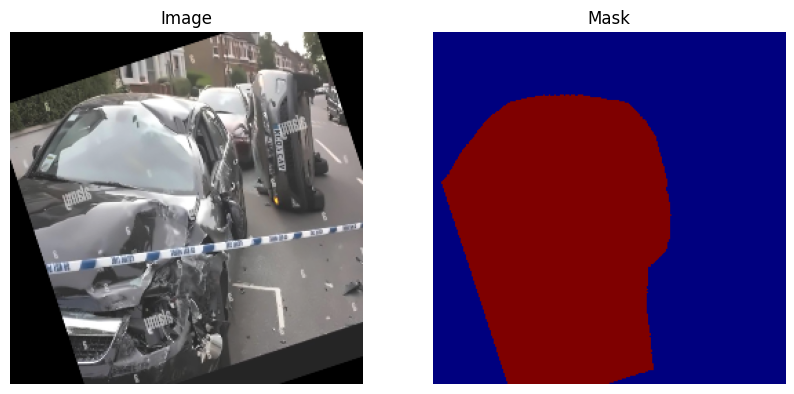

In [17]:
import random

# Pick a random index
idx = random.randint(0, len(train_dataset)-1)
img, mask = train_dataset[idx]

print(f"Image dtype: {img.dtype}, shape: {img.shape}")
print(f"Mask dtype: {mask.dtype}, shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")  # Should be 0,1,2 for multi-class
nm =img.to(torch.float32) / 255.0  # convert to float32 and normalize
print(f"Image dtype: {nm.dtype}, shape: {nm.shape}")

# Convert image to numpy for plotting (C,H,W -> H,W,C)
img_np = img.permute(1,2,0).numpy()

# Plot image and mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask.numpy(), cmap="jet", vmin=0, vmax=2)  # color-coded mask
plt.title("Mask")
plt.axis("off")
plt.show()


In [18]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

In [19]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation=None
).to(DEVICE)

In [21]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [22]:
cross_entropy_criteriation = nn.CrossEntropyLoss()
dice_criteriation = smp.losses.DiceLoss(mode='multiclass')

def loss_function(predication , gt_mask):
    return cross_entropy_criteriation(predication,gt_mask) + dice_criteriation(predication,gt_mask)

In [23]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [24]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [52]:
def train_one_epoch(model,optimizer,data_loader):
    model.train()
    total_loss = 0

    for imgs, masks in data_loader:
        # img: torch.uint8 tensor, shape (C,H,W), values 0-255
        imgs = imgs.to(torch.float32) / 255.0  # convert to float32 and normalize

        imgs,masks = imgs.to(DEVICE), masks.to(DEVICE)

        predictions = model(imgs)

        loss = loss_function(predictions, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [51]:
def valid_one_epoch(model, data_loader):
    model.eval()
    total_loss = 0

    for imgs, masks in data_loader:
        imgs = imgs.to(torch.float32) / 255.0  # convert to float32 and normalize
        
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
    
        loss = loss_function(preds, masks)
    
        total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [27]:
EPOCHS = 10

In [28]:
from tqdm import tqdm

In [29]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU count: 1
Device: NVIDIA GeForce RTX 2050


In [49]:
for epoch in tqdm(range(EPOCHS)):
    train_loss = train_one_epoch(model,optimizer,trainset_loader)
    valid_loss = valid_one_epoch(model, validset_loader)

    print(f"EPOCH {epoch+1}:    Train Loss = {train_loss:.4f}       Validation Loss = {valid_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 10%|█         | 1/10 [00:12<01:50, 12.31s/it]

<class 'torch.Tensor'>
EPOCH 1:    Train Loss = 0.9928       Validation Loss = 0.8971
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 20%|██        | 2/10 [00:24<01:37, 12.16s/it]

EPOCH 2:    Train Loss = 0.9462       Validation Loss = 0.9338
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 30%|███       | 3/10 [00:36<01:24, 12.14s/it]

<class 'torch.Tensor'>
EPOCH 3:    Train Loss = 0.8877       Validation Loss = 0.8942
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 40%|████      | 4/10 [00:48<01:12, 12.12s/it]

<class 'torch.Tensor'>
EPOCH 4:    Train Loss = 0.8683       Validation Loss = 0.8822
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 50%|█████     | 5/10 [01:00<01:00, 12.09s/it]

<class 'torch.Tensor'>
EPOCH 5:    Train Loss = 0.8348       Validation Loss = 0.8034
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 60%|██████    | 6/10 [01:12<00:48, 12.12s/it]

EPOCH 6:    Train Loss = 0.8351       Validation Loss = 0.9319
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 70%|███████   | 7/10 [01:24<00:36, 12.10s/it]

<class 'torch.Tensor'>
EPOCH 7:    Train Loss = 0.7765       Validation Loss = 0.8513
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 80%|████████  | 8/10 [01:37<00:24, 12.15s/it]

EPOCH 8:    Train Loss = 0.7643       Validation Loss = 0.7640
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 90%|█████████ | 9/10 [01:49<00:12, 12.08s/it]

EPOCH 9:    Train Loss = 0.7358       Validation Loss = 0.8759
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


100%|██████████| 10/10 [02:00<00:00, 12.10s/it]

EPOCH 10:    Train Loss = 0.7549       Validation Loss = 0.7569


In [50]:
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [53]:
for epoch in range(EPOCHS*2):
    train_loss = train_one_epoch(model, optimizer, trainset_loader)
    valid_loss = valid_one_epoch(model, validset_loader)
    print(f"[Finetune] Epoch {epoch+1}: Train={train_loss:.4f}, Valid={valid_loss:.4f}")

[Finetune] Epoch 1: Train=0.7372, Valid=0.8643
[Finetune] Epoch 2: Train=0.6366, Valid=0.7458
[Finetune] Epoch 3: Train=0.5337, Valid=0.6704
[Finetune] Epoch 4: Train=0.5031, Valid=0.6703
[Finetune] Epoch 5: Train=0.4667, Valid=0.6309
[Finetune] Epoch 6: Train=0.4730, Valid=0.6543
[Finetune] Epoch 7: Train=0.4231, Valid=0.6509
[Finetune] Epoch 8: Train=0.3908, Valid=0.6651
[Finetune] Epoch 9: Train=0.3933, Valid=0.6454
[Finetune] Epoch 10: Train=0.3647, Valid=0.6020
[Finetune] Epoch 11: Train=0.3588, Valid=0.6737
[Finetune] Epoch 12: Train=0.3646, Valid=0.6442
[Finetune] Epoch 13: Train=0.3410, Valid=0.6555
[Finetune] Epoch 14: Train=0.3367, Valid=0.7331
[Finetune] Epoch 15: Train=0.3283, Valid=0.7641
[Finetune] Epoch 16: Train=0.3101, Valid=0.6318
[Finetune] Epoch 17: Train=0.3036, Valid=0.6640
[Finetune] Epoch 18: Train=0.3118, Valid=0.6342
[Finetune] Epoch 19: Train=0.3364, Valid=0.6334
[Finetune] Epoch 20: Train=0.3064, Valid=0.6023


In [55]:
test_dataset = MaskDataset(
    images_dir=os.path.join(dataset_dir_path,'test/images'), 
    masks_dir=os.path.join(dataset_dir_path,'test/masks'), 
    transforms=valid_tf
)

print(f"Test dataset size: {len(test_dataset)} samples")

Test dataset size: 28 samples


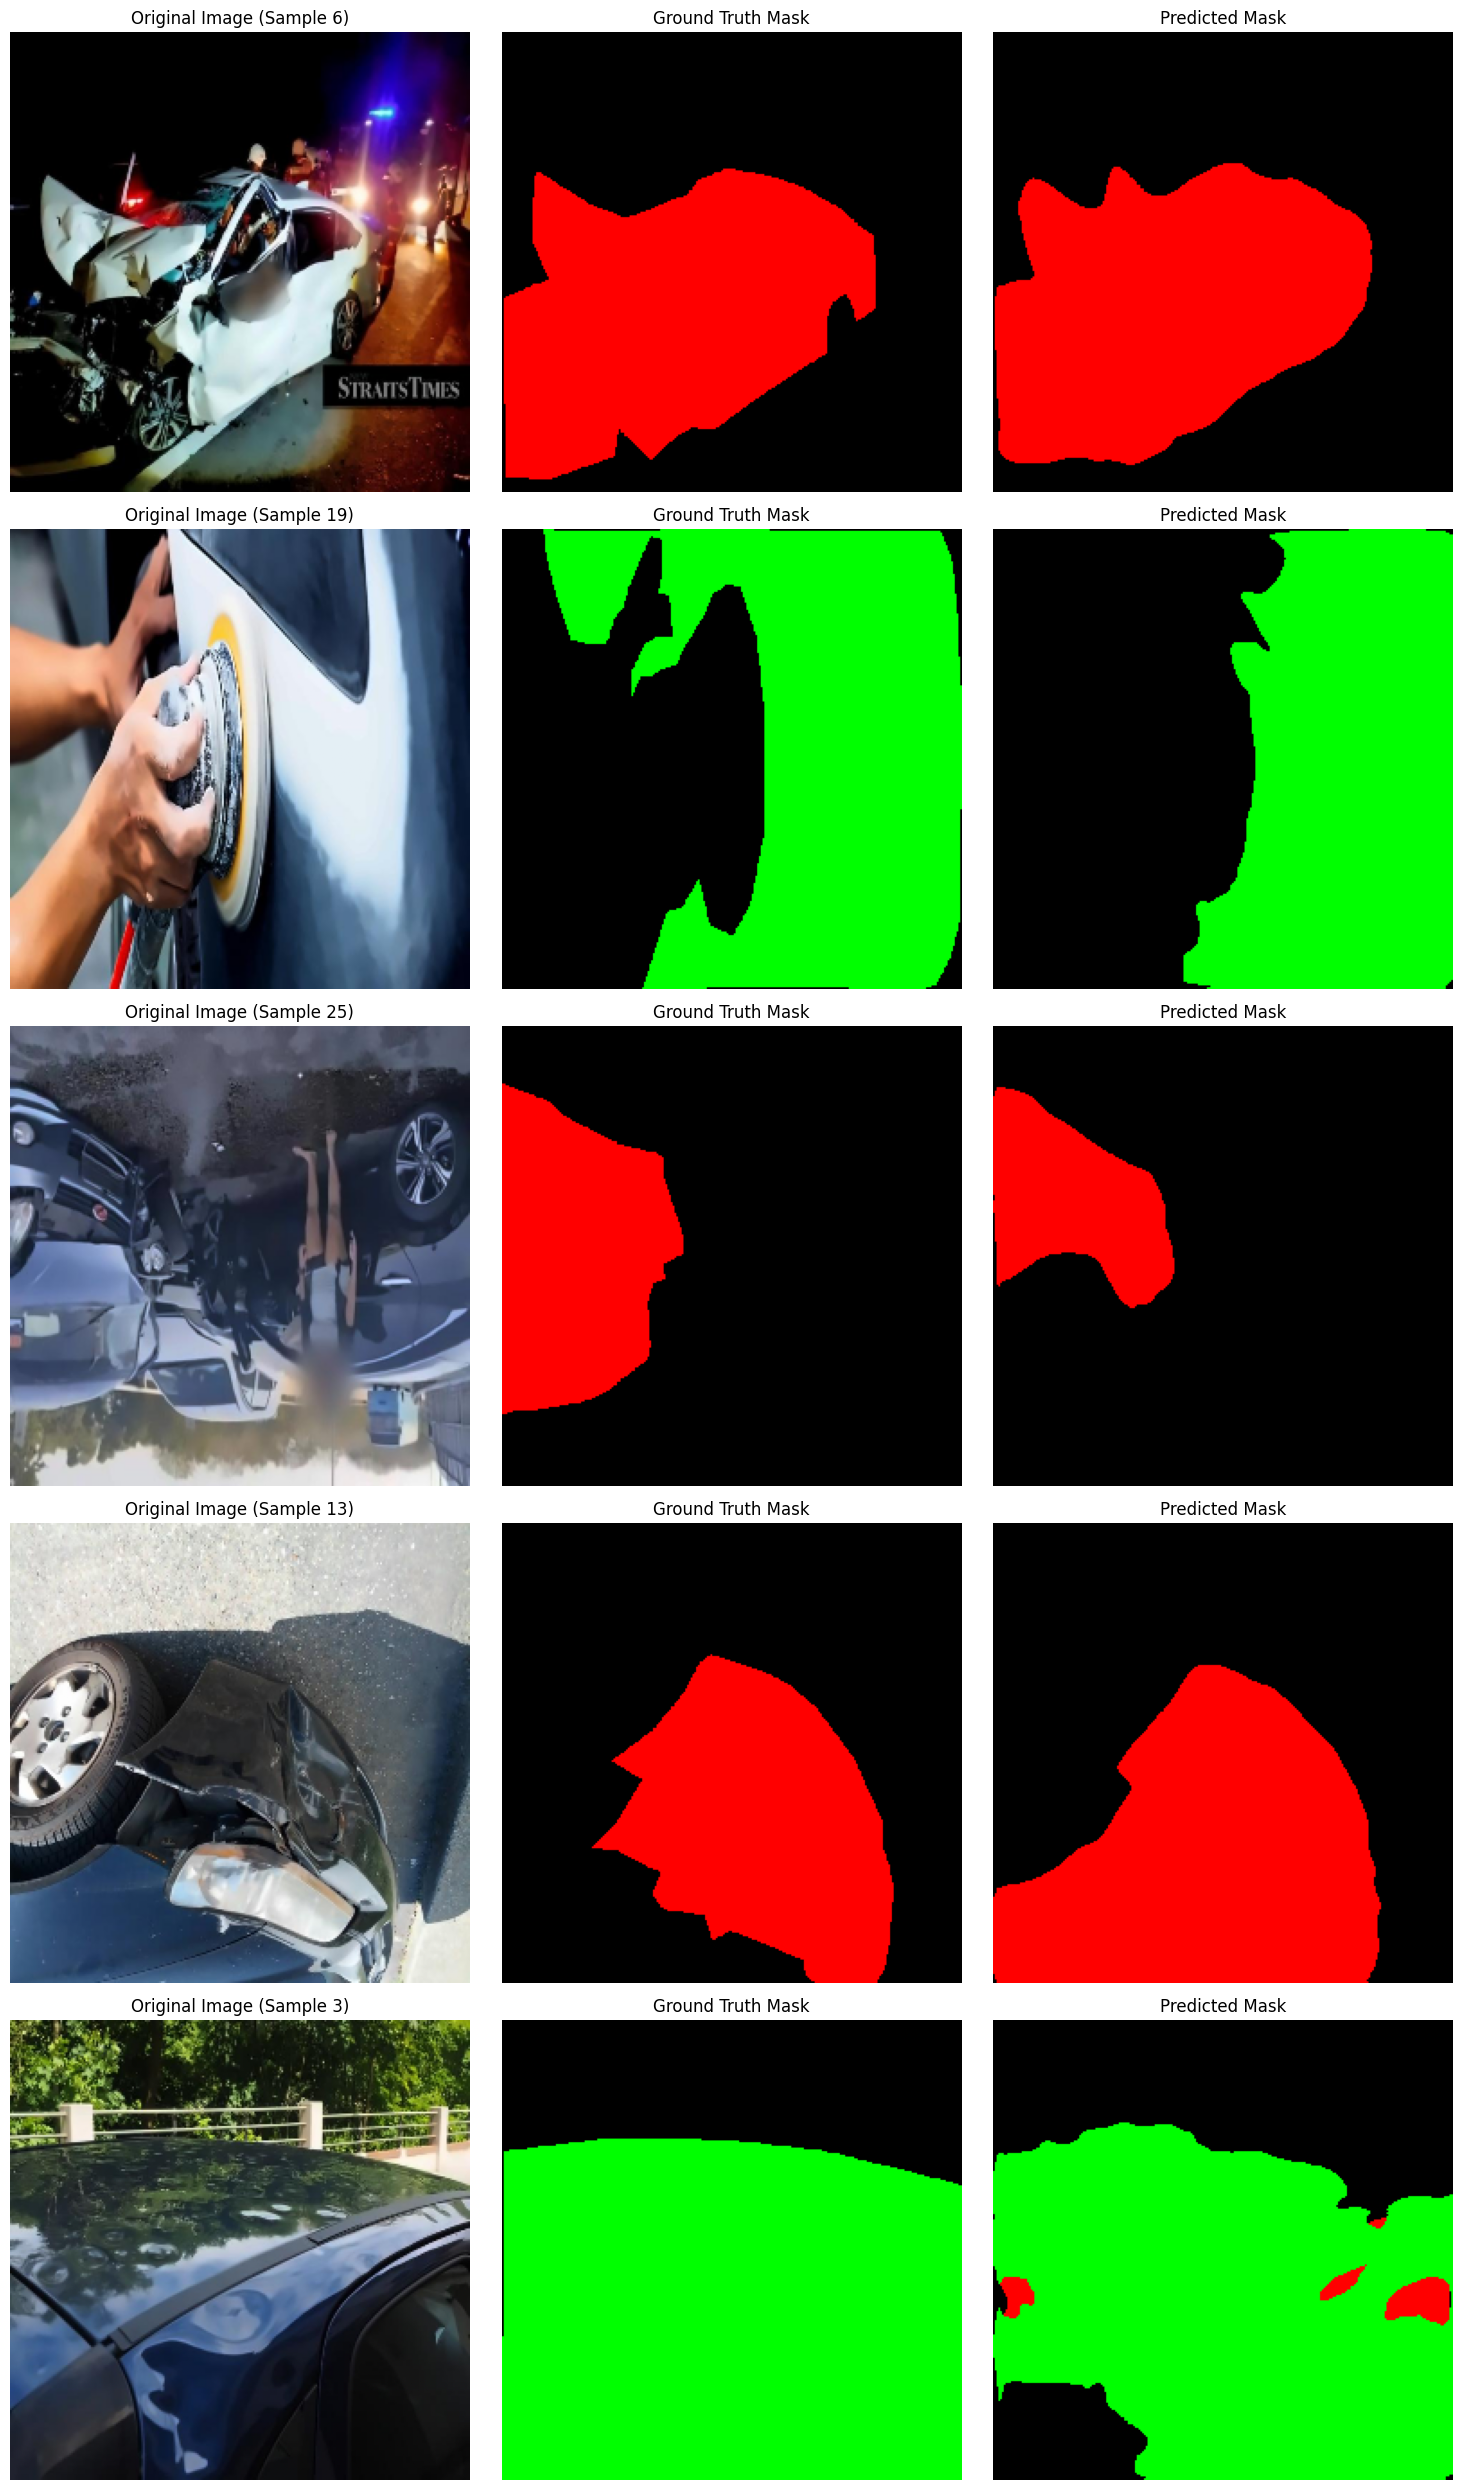

In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

# Define the color map used for visualization (adjust this if your colors are different)
# We assume 3 classes: 0 (Background), 1 (Damage Type A), 2 (Damage Type B)
# If your original classes were different, adjust these colors.
# Example: Black for background, Red for class 1, Green for class 2.
COLOR_MAP = {
    0: (0, 0, 0),       # Black: Background (No damage)
    2: (255, 0, 0),     # Red: Damage Type 1
    1: (0, 255, 0)      # Green: Damage Type 2
}

def decode_mask(mask: np.ndarray, color_map: Dict[int, Tuple[int, int, int]] = COLOR_MAP) -> np.ndarray:
    """
    Converts a grayscale mask of class indices (0, 1, 2) into an RGB image mask 
    using the provided color map.

    Args:
        mask (np.ndarray): The segmentation mask (H, W) with integer class indices.
        color_map (Dict): Dictionary mapping class indices to RGB colors.

    Returns:
        np.ndarray: The resulting RGB color mask (H, W, 3).
    """
    # Ensure the mask is integer type
    mask = mask.astype(np.uint8) 
    
    # Create an empty RGB array
    rgb_mask = np.zeros(mask.shape + (3,), dtype=np.uint8)

    # Apply the color map
    for class_id, color in color_map.items():
        rgb_mask[mask == class_id] = color
        
    return rgb_mask

def visualize_test_results(model: torch.nn.Module, test_dataset: Any, device: str, num_samples: int = 5):
    """
    Performs inference on a subset of the test set and visualizes the 
    Original Image, Ground Truth Mask, and Predicted Mask side-by-side.

    Args:
        model (torch.nn.Module): The trained U-Net model.
        test_dataset (Any): The PyTorch Dataset object for the test data.
        device (str): The device ('cuda' or 'cpu').
        num_samples (int): The number of samples to visualize.
    """
    model.eval()
    
    # Determine which samples to visualize (e.g., the first 'num_samples')
    indices_to_visualize = np.random.choice(len(test_dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(indices_to_visualize):
            # 1. Get the sample from the dataset
            # Note: The output of __getitem__ for your dataset is (img_tensor, mask_tensor)
            img_tensor, gt_mask_tensor = test_dataset[idx]
            img_tensor = img_tensor.to(torch.float32) / 255.0  # convert to float32 and normalize

            # 2. Prepare for prediction: Add batch dimension and move to device
            input_tensor = img_tensor.unsqueeze(0).to(device) # (1, C, H, W)

            # 3. Get Prediction
            output_logits = model(input_tensor) # (1, Classes, H, W)
            
            # 4. Convert logits to mask: Get the class with the highest score
            predicted_mask = torch.argmax(output_logits, dim=1).squeeze(0) # (H, W)
            
            # 5. Convert tensors back to NumPy arrays for plotting
            
            # Original Image (C, H, W) -> (H, W, C), must be floating point (0-1)
            # Assuming you normalize the image from 0-255 to 0-1 in your __getitem__
            original_image = img_tensor.cpu().permute(1, 2, 0).numpy()
            
            # Ground Truth Mask (H, W)
            gt_mask_np = gt_mask_tensor.cpu().numpy()
            
            # Predicted Mask (H, W)
            pred_mask_np = predicted_mask.cpu().numpy()
            
            # 6. Decode masks to colorful RGB images
            gt_rgb_mask = decode_mask(gt_mask_np)
            pred_rgb_mask = decode_mask(pred_mask_np)
            
            # 7. Plotting
            
            # Subplot 1: Original Image
            ax1 = plt.subplot(num_samples, 3, i * 3 + 1)
            ax1.imshow(original_image)
            ax1.set_title(f"Original Image (Sample {idx})")
            ax1.axis('off')

            # Subplot 2: Ground Truth Mask
            ax2 = plt.subplot(num_samples, 3, i * 3 + 2)
            ax2.imshow(gt_rgb_mask)
            ax2.set_title("Ground Truth Mask")
            ax2.axis('off')

            # Subplot 3: Predicted Mask
            ax3 = plt.subplot(num_samples, 3, i * 3 + 3)
            ax3.imshow(pred_rgb_mask)
            ax3.set_title("Predicted Mask")
            ax3.axis('off')
            
    plt.tight_layout()
    plt.show()

# --- HOW TO USE THIS FUNCTION (Place this in your notebook) ---
# Assuming you have defined these variables:
# 1. model (your trained U-Net model)
# 2. test_dataset (your MaskDataset instance for the test set)
# 3. DEVICE (e.g., 'cuda' or 'cpu')

# Example Call:
visualize_test_results(model, test_dataset, DEVICE, num_samples=5)